AttributeError: 'LayerNorm' object has no attribute 'a_2'

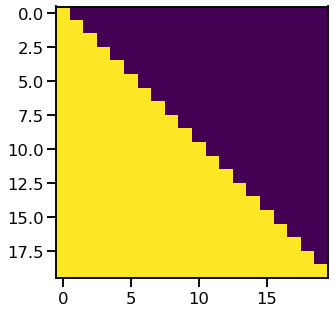

In [28]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn

seaborn.set_context(context='talk')
%matplotlib inline



"""
A standard Encoder-Decoder architecture. Base for this and many 
other models.
上面这句话的意思是：这个类是当前 Attention 也是其他许多模型的基础。也就是encoder-decoder
结构
"""
# 这个类是什么意思？
class EncoderDecoder(nn.Module):
    def __init__(self,encoder,decoder,src_embed,tgt_embed,generator):
        super(EncoderDecoder,self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator  # 这个是做什么的？
    
    def forward(self,src,tgt,src_mask,tgt_mask):
        
        return self.decode(self.encode(src,src_mask),
                          src_mask,
                          tgt,
                          tgt_mask)
    
    def encode(self,src,src_mask):
        return self.encoder(self.src_embed(src),src_mask)
    
    def decode(self,memory,src_mask,tgt,tgt_mask):
        return self.decoder(self.tgt_embed(tgt),
                           memory,
                           src_mask,
                           tgt_mask)
    

class Generator(nn.Module):
    "Define standard linear + softmax generation step"
    def __init__(self,d_model,vocab):
        super(Generator,self).__init__()
        self.proj = nn.Linear(d_model,vocab)  # 这里是取Linear 步骤
    
    def forward(self,x):
        return F.log_softmax(self.proj(x),dim = -1)  # 这里取softmax  

"""下面才是主要的实现
"""
def clones(module,N):
    "produce N identical layers"
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

class Encoder(nn.Module):
    def __init__(self,layer,N):
        super(Encoder,self).__init__()
        self.layers = clones(layer,N) # 论文中的N是6层
        self.norm = LayerNorm(layer.size)
    
    def forward(self,x,mask):
        for layer in self.layers:
            x = layer(x,mask)
        return self.norm(x)

class LayerNorm(nn.Module):
    def __init__(self,features,eps=1e-6):
        super(LayerNorm,self).__init__()
        self.a_2 == nn.Parameter(torch.ones(features))
        self.b_2 == nn.Parameter(torch.zeros(features))
        self.eps = eps
    def forward(self,x):
        "这里的-1？？"
        mean = x.mean(-1,keepdim= True)
        std = x.std(-1,keepdim = True)
        return self.a_2 * (x - mean) / (std+self.eps) + self.b_2

"""这层主要的功能就是实现每个 encoder layer 之间的连接，包括
LayerNorm功能; 残差网络功能
"""
class SublayerConnection(nn.Module):
    def __init__(self,size,dropout):
        super(SublayerConnection,self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self,x,sublayer):
        """
        01.这边就能看出来这是一个残差网络的连接
        首先x就是普通 残差网络中的 虚线；
        self.dropout(sublayer(self.norm(x))) 就是经过网络层处理之后的值
        02.这个sublayer 即是传入的参数
        """        
        return x + self.dropout(sublayer(self.norm(x)))

"""
Encoder is made up of self-attn and feed forward.
"""
class EncoderLayer(nn.Module):
    def __init__(self,size,self_attn,feed_forward,dropout):
        super(EncoderLayer,self).__init__()
        self.self_attn = self_attn  # self-attention 层
        
        """
        这个sublayer 是干什么的？
        => 用于执行LayerNorm 和 Resnet的层，而这两层被放到SublayerConnection
        中了
        """
        self.sublayer = clones(SublayerConnection(size,dropout),2) 
        self.feed_forward = feed_forward # FNN层               
        self.size = size
        
    def forward(self,x,mask):
        x= self.sublayer[0](x,lambda x:self.self_attn(x,x,x,mask))
        return self.sublayer[1](x,self.feed_forward) 

"""
定义这种Decoder 是干什么的？为什么需要？
"""
class Decoder(nn.Module):
    def __init__(self,layer,N):
        super(Decoder,self).__init__()
        self.layers = clones(layer,N) # 传入的是什么layer，就clone什么
        self.norm = LayerNorm(layer.size) # 这里的layer.size 不是很理解
    def forward(self,x,memory,src_mask,tgt_mask):
        for layer in self.layers:
            x = layer(x,memory,src_mask,tgt_mask)
        return self.norm(x)
    


"""
定义实现 Decoder layer
这是我自己定义的
"""
class DecoderLaye(nn.Module):
    def __init__(self,self_attn,mask_attn,feed_forward,sublayer):
        super(DecoderLayer,self).__init__()
        "按照顺序定义网络结构"
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.mask_attn = mask_attn
        self.sublayer = sublayer
                
    # 输入的数据是什么？ => encoder 得到的结果
    def forward(self,x):
        x = self.mask_attn(x) # 先经过masked multi-head attention
        x = self.sublayer(x) #  再由 layerNorm + resnet 处理
        x = self.self_attn(x) # ...
        x = self.sublayer(x)
        x = self.feed_forward(x)
        x = self.sublayer(x)      

class DecoderLayer(nn.Module):
    def __init__(self,size,self_attn,src_attn,feed_forward,dropout):
        super(DecoderLayer,self).__init__()
        self.size = size 
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        # 为什么这里的数字就是3？ 
        # 因为 Add&Norm 这种层在decoder layer中有三个
        self.sublayer = clones(SublayerConnection(size,dropout),3)
    
    # memeory 是干什么的？
    def forward(self,x,memory,src_mask,tgt_mask):
        m = memory
        x = self.sublayer[0](x,lambda x:self.attn(x,x,x,tgt_mask))
        x = self.sublayer[1](x,lambda x:self.src_attn(x,m,m,src_mask))
        return self.sublayer[2](x,self.feed_forward)

def subsequent_mask(size):
    attn_shape = (1,size,size)
    subsequent_mask = np.triu(np.ones(attn_shape),k = 1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

plt.figure(figsize=(5,5))
plt.imshow(subsequent_mask(20)[0])

"""
定义至关重要的 attention 函数
01.观察需要哪些参数
"""
def attention(query,key,value,mask=None,dropout=None):
    d_k = query.size(-1)
    scores = torch.matmul(query,key.transpose(-2,-1)) / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0,-1e9)
    p_attn = F.softmax(scores,dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn,value), p_attn

"""
实现multi-head attention
不过这里直接定义了一个类，为什么不是函数呢？
"""
class MultiHeadedAttention(nn.Module):
    def __init__(self,h,d_model,dropout = 0.1):
        super(MultiHeadedAttention,self).__init__()
        assert d_model %h == 0
        self.d_k = d_model // h
        self.h = h 
        self.linears = clones(nn.Linear(d_model,d_model),4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
    def forward(self,query,key,value,mask = None):
        if mask is not None:
            mask = mask.unsqueeze(1)
        nbatches= query.size(0)
          
        # 1) Do all the linear projections in batch from d_model => h x d_k 
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]
        
        # 2) Apply attention on all the projected vectors in batch. 
        x, self.attn = attention(query, key, value, mask=mask, 
                                 dropout=self.dropout)
        
        # 3) "Concat" using a view and apply a final linear. 
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)

class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

class Embeddings(nn.Module):
    """
    这里的vocab 是什么？
    """
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)

    
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], 
                         requires_grad=False)
        return self.dropout(x)
    
     

def make_model(src_vocab, tgt_vocab, N=6, 
               d_model=512, d_ff=2048, h=8, dropout=0.1):
    "Helper: Construct a model from hyperparameters."
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), 
                             c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab))
    
    # This was important from their code. 
    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform(p)
    return model


class Batch:
    "Object for holding a batch of data with mask during training."
    def __init__(self, src, trg=None, pad=0):
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        if trg is not None:
            self.trg = trg[:, :-1]
            self.trg_y = trg[:, 1:]
            self.trg_mask = \
                self.make_std_mask(self.trg, pad)
            self.ntokens = (self.trg_y != pad).data.sum()
    
    @staticmethod
    def make_std_mask(tgt, pad):
        "Create a mask to hide padding and future words."
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & Variable(
            subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
        return tgt_mask

def run_epoch(data_iter, model, loss_compute):
    "Standard Training and Logging Function"
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    for i, batch in enumerate(data_iter):
        out = model.forward(batch.src, batch.trg, 
                            batch.src_mask, batch.trg_mask)
        loss = loss_compute(out, batch.trg_y, batch.ntokens)
        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens
        if i % 50 == 1:
            elapsed = time.time() - start
            print("Epoch Step: %d Loss: %f Tokens per Sec: %f" %
                    (i, loss / batch.ntokens, tokens / elapsed))
            start = time.time()
            tokens = 0
    return total_loss / total_tokens


global max_src_in_batch, max_tgt_in_batch
def batch_size_fn(new, count, sofar):
    "Keep augmenting batch and calculate total number of tokens + padding."
    global max_src_in_batch, max_tgt_in_batch
    if count == 1:
        max_src_in_batch = 0
        max_tgt_in_batch = 0
    max_src_in_batch = max(max_src_in_batch,  len(new.src))
    max_tgt_in_batch = max(max_tgt_in_batch,  len(new.trg) + 2)
    src_elements = count * max_src_in_batch
    tgt_elements = count * max_tgt_in_batch
    return max(src_elements, tgt_elements)


class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))
        
def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 2, 4000,
            torch.optim.Adam(model.parameters(), 
                             lr=0,
                             betas=(0.9, 0.98), 
                             eps=1e-9))


class LabelSmoothing(nn.Module):
    "Implement label smoothing."
    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(size_average=False)
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
        
    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, Variable(true_dist, requires_grad=False))

    
def data_gen(V, batch, nbatches):
    "Generate random data for a src-tgt copy task."
    for i in range(nbatches):
        data = torch.from_numpy(np.random.randint(1, V, size=(batch, 10)))
        data[:, 0] = 1
        src = Variable(data, requires_grad=False)
        tgt = Variable(data, requires_grad=False)
        yield Batch(src, tgt, 0)


class SimpleLossCompute:
    "A simple loss compute and train function."
    def __init__(self, generator, criterion, opt=None):
        self.generator = generator
        self.criterion = criterion
        self.opt = opt
        
    def __call__(self, x, y, norm):
        x = self.generator(x)
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)), 
                              y.contiguous().view(-1)) / norm
        loss.backward()
        if self.opt is not None:
            self.opt.step()
            self.opt.optimizer.zero_grad()
        return loss.data[0] * norm

# Train the simple copy task.
V = 11
criterion = LabelSmoothing(size=V, padding_idx=0, smoothing=0.0)
model = make_model(V, V, N=2)
model_opt = NoamOpt(model.src_embed[0].d_model,
                    1,400,
                    torch.optim.Adam(model.parameters(),
                    lr=0,betas=(0.9, 0.98), eps=1e-9))

for epoch in range(10):
    model.train()
    run_epoch(data_gen(V, 30, 20), model, 
              SimpleLossCompute(model.generator, criterion, model_opt))
    model.eval()
    print(run_epoch(data_gen(V, 30, 5),
                    model, 
                    SimpleLossCompute(model.generator, criterion, None)))

    
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type_as(src.data)
    for i in range(max_len-1):
        out = model.decode(memory, src_mask, 
                           Variable(ys), 
                           Variable(subsequent_mask(ys.size(1))
                                    .type_as(src.data)))
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim = 1)
        next_word = next_word.data[0]
        ys = torch.cat([ys, 
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
    return ys

model.eval()
src = Variable(torch.LongTensor([[1,2,3,4,5,6,7,8,9,10]]) )
src_mask = Variable(torch.ones(1, 1, 10) )
print(greedy_decode(model, src, src_mask, max_len=10, start_symbol=1))
